<a href="https://colab.research.google.com/github/Tillmawitz/data_620/blob/main/final/Tillmawitz_data_620_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data 620 Final Project
**Matthew Tillmawitz**

For this project we will be using the 20 newsgroups dataset to evaluate different text encoding methods. The dataset consists of 18,000 newsgroup documents which are a part of one of the 20 newsgroups. Recent developments in machine learning, natural language processing, and transformers have lead to a number of encoding models which produce numeric representations of text called embeddings which, it is claimed, better represent the "meaning" or significant aspects of texts than traditional features or methods. We will be using the newsgroups dataset to evaluate this claim by encoding the text of each document using TF-IDF, the all-MiniLM-L6-v2 model, and the bge-base-en-v1.5 model. We then construct graphs from these document representations using knn and cosine similarity and conduct community detection using a range of methods to evaluate whether the model embeddings are truly an improvement over the traditional TF-IDF method. Experiment design choices will be explained in further detail in the relevant sections, and final conclusions will be drawn at the end.

## Initial Data Analysis and Encoding

As this dataset is well known, we will not be conducting extensive analysis of it and will simply validate the 20 topic groups and note that there is a largely even split among the topics with a few outliers having 200-300 documents less than the average. Traditionally, the documents have a body, headers, footers, and quote any documents that are replied to. As our focus is strictly on the impact of different representations of the text, we will only be encoding the body of each document and disregarding the other fields. Information in the other parts of the documents can be highly informative or be used to inform the construction of the graphs, however, doing so would add additional confounding variables that would cloud our analysis due to the varying levels of conectedness and information in these fields from community to community. By focussing solely on the body text we will be able to more fairly evaluate the information gain of the different text encoding methods. The encoding methods were chosen to represent different advancements in text encoding, with TF-IDF having a long history as an effective encoding method predating transformers and remaining competitive. The all-MiniLM-L6-v2 model is a sentence transformer that is well established in the research community, while the bge-base-en-v1.5 model is a more recent sentence transformer that has shown promise. Comparing these encoders will give us an indication of whether encoders provide meaningful information gain and whether more recent models are indeed improvements over earlier models or if they are plateauing.

In [ ]:
!pip install scikit-learn sentence-transformers gensim networkx torch-geometric faiss-gpu-cu12 python-louvain -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 108.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 MB 58.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pickle
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, homogeneity_score, completeness_score, v_measure_score
import community as community_louvain
from sentence_transformers import SentenceTransformer
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torch_geometric.utils import from_networkx
from torch_geometric.nn import SAGEConv
from torch_geometric.loader import NeighborLoader
from google.colab import drive
import os
import networkx as nx
from scipy.sparse import csr_matrix
import faiss
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
drive.mount('/content/drive', force_remount=True)

project_dir = '/content/drive/MyDrive/data/Data_620/final_project'
embeddings_dir = os.path.join(project_dir, 'embeddings')
networks_dir = os.path.join(project_dir, 'networks')
pyg_graphs_dir = os.path.join(project_dir, 'pyg_graphs')
results_dir = os.path.join(project_dir, 'community_results')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Mounted at /content/drive


In [ ]:
print("Loading 20 Newsgroups dataset...")
newsgroups_all = fetch_20newsgroups(
    subset='all',
    remove=('headers', 'footers', 'quotes'),
    shuffle=True,
    random_state=8675309
)

data_df = pd.DataFrame({
    'text': newsgroups_all.data,
    'target': newsgroups_all.target,
    'target_name': [newsgroups_all.target_names[i] for i in newsgroups_all.target]
})

print(f"Total documents: {len(data_df)}")
print(f"Categories: {len(newsgroups_all.target_names)}")
print("\nCategory distribution:")
print(data_df['target_name'].value_counts().sort_index())

Loading 20 Newsgroups dataset...
Total documents: 18846
Categories: 20

Category distribution:
target_name
alt.atheism                 799
comp.graphics               973
comp.os.ms-windows.misc     985
comp.sys.ibm.pc.hardware    982
comp.sys.mac.hardware       963
comp.windows.x              988
misc.forsale                975
rec.autos                   990
rec.motorcycles             996
rec.sport.baseball          994
rec.sport.hockey            999
sci.crypt                   991
sci.electronics             984
sci.med                     990
sci.space                   987
soc.religion.christian      997
talk.politics.guns          910
talk.politics.mideast       940
talk.politics.misc          775
talk.religion.misc          628
Name: count, dtype: int64


In [ ]:
texts = data_df['text'].tolist()

tfidf_cache_path = os.path.join(embeddings_dir, 'tfidf_embeddings.npz')
vectorizer_path = os.path.join(embeddings_dir, 'tfidf_vectorizer.pkl')

tfidf_embeddings = None
tfidf_vectorizer = None

if os.path.exists(tfidf_cache_path):
    print("Loading cached TF-IDF embeddings...")
    tfidf_embeddings = np.load(tfidf_cache_path)['embeddings']
    with open(vectorizer_path, 'rb') as f:
        tfidf_vectorizer = pickle.load(f)
    print(f"TF-IDF shape: {tfidf_embeddings.shape}")
else:
    print("Generating TF-IDF embeddings...")
    tfidf_vectorizer = TfidfVectorizer(
        max_features=5000,
        min_df=5,
        max_df=0.7,
        stop_words='english',
        sublinear_tf=True
    )
    tfidf_embeddings = tfidf_vectorizer.fit_transform(texts).toarray()

    # Save
    np.savez_compressed(tfidf_cache_path, embeddings=tfidf_embeddings)
    with open(vectorizer_path, 'wb') as f:
        pickle.dump(tfidf_vectorizer, f)

    print(f"TF-IDF shape: {tfidf_embeddings.shape}")
    print(f"Saved to {tfidf_cache_path}")

if tfidf_embeddings is None or tfidf_vectorizer is None:
    raise ValueError("TF-IDF embeddings not loaded")


Loading cached TF-IDF embeddings...
TF-IDF shape: (18846, 5000)


In [ ]:
minilm_cache_path = os.path.join(embeddings_dir, 'minilm_embeddings.npy')
minilm_embeddings = None

if os.path.exists(minilm_cache_path):
    print("Loading cached MiniLM Transformer embeddings...")
    minilm_embeddings = np.load(minilm_cache_path)
    print(f"MiniLM Transformer shape: {minilm_embeddings.shape}")
else:
    print("Generating MiniLM Transformer embeddings...")
    model = SentenceTransformer('all-MiniLM-L6-v2', device=device)
    minilm_embeddings = model.encode(texts, batch_size=2048, show_progress_bar=True, convert_to_numpy=True, device=device)

    np.save(minilm_cache_path, minilm_embeddings)
    print(f"MiniLM Transformer shape: {minilm_embeddings.shape}")
    print(f"Saved to {minilm_cache_path}")

    # Clear GPU memory
    del model
    torch.cuda.empty_cache()

if minilm_embeddings is None:
    raise ValueError("MiniLM Transformer embeddings not loaded")

Loading cached MiniLM Transformer embeddings...
MiniLM Transformer shape: (18846, 384)


In [ ]:
# Change model name for saving etc. to remove slash
model_name='BAAI/bge-base-en-v1.5'
safe_model_name = model_name.replace('/', '_')
normalize_embeddings = True

bge_cache_path = os.path.join(embeddings_dir, f'{safe_model_name}_embeddings.npy')
bge_embeddings = None

if os.path.exists(bge_cache_path):
    print(f"Loading cached {model_name} embeddings...")
    bge_embeddings = np.load(bge_cache_path)
    print(f"{model_name} shape: {bge_embeddings.shape}")
else:
    print(f"Generating {model_name} embeddings...")
    model = SentenceTransformer(model_name, device=device)

    bge_embeddings = model.encode(texts, batch_size=512, show_progress_bar=True, convert_to_numpy=True, device=device, normalize_embeddings=normalize_embeddings)

    np.save(bge_cache_path, bge_embeddings)
    print(f"{model_name} shape: {bge_embeddings.shape}")
    print(f"Saved to {bge_cache_path}")

    del model
    torch.cuda.empty_cache()

if bge_embeddings is None:
    raise ValueError(f"{model_name} embeddings not loaded")

Loading cached BAAI/bge-base-en-v1.5 embeddings...
BAAI/bge-base-en-v1.5 shape: (18846, 768)


We can see from the object shapes above and the metadata below there is a significant difference in the number of features produced by the different encoding methods. The dimensionality of the document representations is an important factor when evaluating the different encoding methods, as lower dimensional representations can save a significant amount of storage space. When training large deep learning models memory can quickly become a limiting factor, meaning smaller representations that retain similar levels of information are preferable.

In [ ]:
# For sanity checking and later reference
metadata = {
    'n_documents': len(data_df),
    'n_categories': len(newsgroups_all.target_names),
    'category_names': newsgroups_all.target_names,
    'embeddings': {
        'tfidf': {
            'shape': tfidf_embeddings.shape,
            'type': 'sparse (converted to dense)',
            'max_features': 5000,
            'path': 'tfidf_embeddings.npz'
        },
        'minilm': {
            'shape': minilm_embeddings.shape,
            'model': 'all-MiniLM-L6-v2',
            'type': 'transformer',
            'dims': 384,
            'path': 'all-MiniLM-L6-v2_embeddings.npy'
        },
        'bge': {
            'shape': bge_embeddings.shape,
            'model': 'BAAI/bge-base-en-v1.5',
            'type': 'transformer',
            'dims': 768,
            'normalized': normalize_embeddings,
            'path': 'BAAI_bge-base-en-v1.5_embeddings.npy'
        }
    }
}

with open(os.path.join(project_dir, 'metadata.pkl'), 'wb') as f:
    pickle.dump(metadata, f)

print("\nMetadata saved!")


Metadata saved!


# Graph Construction

Having produced the embeddings, we can now construct a graph to represent similarities between documents. As previously mentioned, the original documents do contain information in the form of authors and reply chains which could be used to construct a more "authentic" representation of the relationships between documents, however, this would be counterproductive for our stated goals. We are evaluating the effectiveness of different encoding methods, and will therefore be relying solely on the encodings themselves to produce the graph. We will be using knn with cosine similarity as our distance metric, connecting the 10 most similar documents for each node. Given the simplicity of cosine similarity, the large difference in dimensionality between the encoding methods, and the assumed differences in the nature of the embeddings we would expect this method of graph construction to produce meaningfully different graph structures for the different encodings which will serve to highlight their efficacy in representing the nature of the documents.

In [ ]:
# Graph construction is the same process, using a function
def build_knn_graph(embeddings, k=10, embedding_name='unnamed', metric='cosine'):
    cache_path = os.path.join(project_dir, f'{embedding_name}_k{k}_graph.pkl')

    if os.path.exists(cache_path):
        print(f"Loading cached {embedding_name} k={k} graph...")
        with open(cache_path, 'rb') as f:
            G = pickle.load(f)
            n_docs, dim = embeddings.shape
            # Print statistics
            print(f"\nGraph Statistics for {embedding_name} (k={k}):")
            print(f"  Nodes: {G.number_of_nodes()}")
            print(f"  Edges: {G.number_of_edges()}")
            print(f"  Average degree: {2 * G.number_of_edges() / G.number_of_nodes():.2f}")
            print(f"  Connected components: {nx.number_connected_components(G)}")

            largest_cc = max(nx.connected_components(G), key=len)
            print(f"  Largest component size: {len(largest_cc)} ({100*len(largest_cc)/n_docs:.1f}%)")
            return G

    print(f"\nBuilding k-NN graph for {embedding_name} (k={k}) using FAISS...")
    n_docs, dim = embeddings.shape

    print("Normalizing embeddings...")
    # Normalize embeddings for cosine similarity
    embeddings_normalized = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    embeddings_normalized = embeddings_normalized.astype('float32')

    print("Building FAISS index on GPU...")
    res = faiss.StandardGpuResources()
    # Inner product = cosine for normalized vectors
    index = faiss.GpuIndexFlatIP(res, dim)
    index.add(embeddings_normalized)

    # Search for k+1 neighbors (includes self)
    print("Searching for k-nearest neighbors...")
    distances, indices = index.search(embeddings_normalized, k + 1)

    print("Building NetworkX graph...")
    G = nx.Graph()
    G.add_nodes_from(range(n_docs))

    edges_to_add = []
    for i in tqdm(range(n_docs), desc="Adding edges"):
        # Skip first neighbor (self)
        neighbors = indices[i][1:]
        neighbor_dists = distances[i][1:]

        for j, dist in zip(neighbors, neighbor_dists):
            if i < j:  # Add edge only once
                edges_to_add.append((i, int(j)))

    G.add_edges_from(edges_to_add)

    with open(cache_path, 'wb') as f:
        pickle.dump(G, f)

    # Print statistics
    print(f"\nGraph Statistics for {embedding_name} (k={k}):")
    print(f"  Nodes: {G.number_of_nodes()}")
    print(f"  Edges: {G.number_of_edges()}")
    print(f"  Average degree: {2 * G.number_of_edges() / G.number_of_nodes():.2f}")
    print(f"  Connected components: {nx.number_connected_components(G)}")

    largest_cc = max(nx.connected_components(G), key=len)
    print(f"  Largest component size: {len(largest_cc)} ({100*len(largest_cc)/n_docs:.1f}%)")

    return G

Having constructed the graphs, we can make some initial observations. As expected, the graphs all have an average degree slightly below 10 and have a single dominant component. Interestingly, the TF-IDF and bge graphs have some striking similarities, with very similar average degrees, number of components, and largest component size. The minilm embeddings produced far fewer components than the other two methods which may be due to lower dimensionality compared to the other two encoding methods.

In [ ]:
k_value = 10
graphs = {}

graphs['tfidf'] = build_knn_graph(tfidf_embeddings, k=k_value, embedding_name='tfidf')
graphs['minilm'] = build_knn_graph(minilm_embeddings, k=k_value, embedding_name='minilm')
graphs['bge'] = build_knn_graph(bge_embeddings, k=k_value, embedding_name='bge')

Loading cached tfidf k=10 graph...

Graph Statistics for tfidf (k=10):
  Nodes: 18846
  Edges: 90752
  Average degree: 9.63
  Connected components: 651
  Largest component size: 18195 (96.5%)
Loading cached minilm k=10 graph...

Graph Statistics for minilm (k=10):
  Nodes: 18846
  Edges: 91962
  Average degree: 9.76
  Connected components: 258
  Largest component size: 18589 (98.6%)
Loading cached bge k=10 graph...

Graph Statistics for bge (k=10):
  Nodes: 18846
  Edges: 91177
  Average degree: 9.68
  Connected components: 593
  Largest component size: 18157 (96.3%)


In [ ]:
embeddings_dict = {
    'tfidf': tfidf_embeddings,
    'minilm': minilm_embeddings,
    'bge': bge_embeddings
}
def networkx_to_pyg(G, node_features, device='cuda'):
    pyg_data = from_networkx(G)
    pyg_data.x = torch.FloatTensor(node_features).to(device)
    return pyg_data

pyg_graphs = {}
for emb_name in ['tfidf', 'minilm', 'bge']:
    print(f"\nConverting {emb_name} graph...")
    pyg_data = networkx_to_pyg(
        graphs[emb_name],
        embeddings_dict[emb_name],
        device='cpu'  # Keep on CPU for now, doesn't take long
    )

    # Save
    save_path = os.path.join(pyg_graphs_dir, f'{emb_name}_k{k_value}_pyg.pt')
    torch.save(pyg_data, save_path)
    print(f"Saved to {save_path}")

    pyg_graphs[emb_name] = pyg_data

    # Print info
    print(f"  Nodes: {pyg_data.num_nodes}")
    print(f"  Edges: {pyg_data.num_edges}")
    print(f"  Features: {pyg_data.x.shape}")


Converting tfidf graph...
Saved to /content/drive/MyDrive/data/Data_620/final_project/pyg_graphs/tfidf_k10_pyg.pt
  Nodes: 18846
  Edges: 181504
  Features: torch.Size([18846, 5000])

Converting minilm graph...
Saved to /content/drive/MyDrive/data/Data_620/final_project/pyg_graphs/minilm_k10_pyg.pt
  Nodes: 18846
  Edges: 183924
  Features: torch.Size([18846, 384])

Converting bge graph...
Saved to /content/drive/MyDrive/data/Data_620/final_project/pyg_graphs/bge_k10_pyg.pt
  Nodes: 18846
  Edges: 182354
  Features: torch.Size([18846, 768])


Digging further into the graphs, we can see that in spite of our initial observations there are some significant differences between the graphs. While the TF-IDF and bge graphs have similar degree distributions, there is a more pronounced tail to the clustering coefficient of the bge graph hinting at a meaningfully different internal structure.

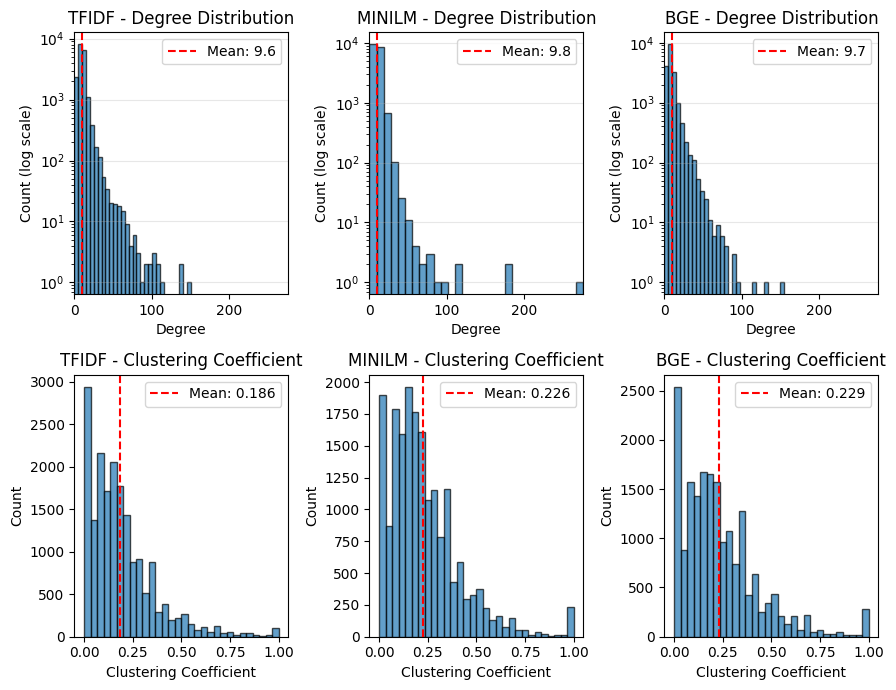

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(9, 7))

all_degrees = []
for G in graphs.values():
    all_degrees.extend([d for n, d in G.degree()])
max_degree = max(all_degrees)

for idx, (name, G) in enumerate(graphs.items()):
    # Degree distribution
    degrees = [d for n, d in G.degree()]
    axes[0, idx].hist(degrees, bins=30, edgecolor='black', alpha=0.7, log=True)
    axes[0, idx].set_title(f'{name.upper()} - Degree Distribution')
    axes[0, idx].set_xlabel('Degree')
    axes[0, idx].set_ylabel('Count (log scale)')
    axes[0, idx].axvline(np.mean(degrees), color='red',
                        linestyle='--', label=f'Mean: {np.mean(degrees):.1f}')
    axes[0, idx].legend()
    axes[0, idx].set_xlim([0, max_degree])  # Consistent x-axis
    axes[0, idx].grid(alpha=0.3, axis='y')

    # Clustering coefficient distribution
    clustering = nx.clustering(G)
    clustering_values = list(clustering.values())
    axes[1, idx].hist(clustering_values, bins=30, edgecolor='black', alpha=0.7)
    axes[1, idx].set_title(f'{name.upper()} - Clustering Coefficient')
    axes[1, idx].set_xlabel('Clustering Coefficient')
    axes[1, idx].set_ylabel('Count')
    axes[1, idx].axvline(np.mean(clustering_values), color='red',
                        linestyle='--', label=f'Mean: {np.mean(clustering_values):.3f}')
    axes[1, idx].legend()

plt.tight_layout()
plt.show()

# Community Detection

Community detection is the chosen method of evaluation for our analysis. As we know there are 20 different communities present, attempting to properly reconstruct these communities from the embeddings and graphs we have created will provide meaningful insight into the quality of the representations produced by our different encoding methods. We will use several methods of community detection in order to fairly evaluate the different encoding methods, with differing levels of sophistication. The Louvain method is a greedy algorithm that seeks to develop non-overlapping communities by optimizing for modularity and has been demonstrated to perform well at problems like ours. Label propogation is a semi-supervised method of community detection that is commonly applied to text embeddings. Our final method of community detection makes use of a Graph Neural Network architecture called GraphSAGE which is trained in a self-supervised manner. The model learns node representations and the graph structure by attempting link prediction resulting in similar representations for nodes with edges present in the graph. We can then use k-means clustering to construct the communities based on these learned representtations and evaluate the result. The inclusion of a well established GNN for community detection will address the argument that the model-produced embeddings contain information or relationships that cannot be adequately utilized by simpler methods. If there is meaningful information gain present in any of the embeddings, a GNN would be able to learn it.

The metrics we will be using to evaluate community detection are: normalized mutual information, adjusted rand index, and modularity. Normalized mutual information (NMI) is commonly used in information theory and is a standard metric for community detection. It measures agreement between the detected communities and the ground truth, accounting for differences in numbers of clusters and is not sensitive to cluster size imbalances. The adjusted rand index (ARI) is a measure of similarity between clusters adjusted for chance. It evaluates pairwise agreement between documents in clusters and is complimentary to NMI. Modularity is a measure of the density of edges within a community vs between communities, with higher values indicating many internal connections and few external connections.

In [ ]:
def louvain_communities(G, save_dir):
    cache_path = os.path.join(save_dir, f'louvain_communities.pkl')

    if os.path.exists(cache_path):
        print(f"Loading cached louvain communities...")
        with open(cache_path, 'rb') as f:
            return pickle.load(f)

    print(f"Running louvain community detection...")

    # Louvain algorithm
    partition = community_louvain.best_partition(G, random_state=8675309)

    # Convert to array format (node_id -> community_id)
    communities = np.array([partition[i] for i in range(len(partition))])

    with open(cache_path, 'wb') as f:
        pickle.dump(communities, f)

    print(f"  Detected {len(set(communities))} communities")
    return communities

def label_propagation(G, save_dir):
    cache_path = os.path.join(save_dir, f'label_prop_communities.pkl')

    if os.path.exists(cache_path):
        print(f"Loading cached label_prop communities...")
        with open(cache_path, 'rb') as f:
            return pickle.load(f)

    print(f"Running label_prop community detection...")

    # Label propagation
    communities_dict = nx.algorithms.community.label_propagation_communities(G)

    # Convert to array format
    communities = np.zeros(G.number_of_nodes(), dtype=int)
    for comm_id, comm_nodes in enumerate(communities_dict):
        for node in comm_nodes:
            communities[node] = comm_id

    with open(cache_path, 'wb') as f:
        pickle.dump(communities, f)

    print(f"  Detected {len(communities_dict)} communities")
    return communities

def evaluate(ground_truth, communities, method_name='', graph_name=''):
    # Handle disconnected components - only evaluate nodes in communities
    valid_mask = communities >= 0  # Assuming -1 for unassigned
    communities_clean = communities[valid_mask]
    ground_truth_clean = ground_truth[valid_mask]

    metrics = {
        'method': method_name,
        'graph': graph_name,
        'n_communities': len(set(communities_clean)),
        'n_ground_truth': len(set(ground_truth_clean)),

        # Primary metrics
        'nmi': normalized_mutual_info_score(ground_truth_clean, communities_clean),
        'ari': adjusted_rand_score(ground_truth_clean, communities_clean),

        # Additional metrics
        'homogeneity': homogeneity_score(ground_truth_clean, communities_clean),
        'completeness': completeness_score(ground_truth_clean, communities_clean),
        'v_measure': v_measure_score(ground_truth_clean, communities_clean),
    }

    return metrics

def evaluate_modularity(G, communities):
    # Convert communities array to dict format for NetworkX
    partition = {i: int(communities[i]) for i in range(len(communities))}
    modularity = community_louvain.modularity(partition, G)
    return modularity

In [ ]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2):
        super(GraphSAGE, self).__init__()

        self.num_layers = num_layers
        self.convs = torch.nn.ModuleList()

        # First layer
        self.convs.append(SAGEConv(in_channels, hidden_channels))

        # Hidden layers
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))

        # Output layer
        self.convs.append(SAGEConv(hidden_channels, out_channels))

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < self.num_layers - 1:
                x = F.relu(x)
                x = F.dropout(x, p=0.5, training=self.training)
        return x

    def encode(self, x, edge_index):
        return self.forward(x, edge_index)


def unsupervised_loss(z, edge_index, num_neg_samples=1):
    # Positive samples (actual edges)
    pos_edge_index = edge_index

    # Negative samples (random node pairs)
    num_nodes = z.size(0)
    num_pos = pos_edge_index.size(1)

    neg_edge_index = torch.randint(
        0, num_nodes,
        (2, num_pos * num_neg_samples),
        device=z.device
    )

    # Compute similarities
    pos_src = z[pos_edge_index[0]]
    pos_dst = z[pos_edge_index[1]]
    pos_score = (pos_src * pos_dst).sum(dim=1)

    neg_src = z[neg_edge_index[0]]
    neg_dst = z[neg_edge_index[1]]
    neg_score = (neg_src * neg_dst).sum(dim=1)

    # Binary cross-entropy loss
    pos_loss = -torch.log(torch.sigmoid(pos_score) + 1e-15).mean()
    neg_loss = -torch.log(1 - torch.sigmoid(neg_score) + 1e-15).mean()

    return pos_loss + neg_loss


class GraphSAGECommunityDetector:
    def __init__(self, save_dir, device='cuda'):
        self.save_dir = save_dir
        self.device = device
        os.makedirs(save_dir, exist_ok=True)

    def train_graphsage(self, data, hidden_channels=128, out_channels=64, num_layers=2, epochs=100, lr=0.01, method_name='graphsage'):
        model_path = os.path.join(self.save_dir, f'{method_name}_model.pt')
        embeddings_path = os.path.join(self.save_dir, f'{method_name}_embeddings.npy')

        # Check if already trained
        if os.path.exists(embeddings_path):
            print(f"Loading cached {method_name} embeddings...")
            embeddings = np.load(embeddings_path)
            return embeddings

        print(f"Training {method_name} model...")
        print(f"  Input features: {data.x.shape[1]}")
        print(f"  Hidden channels: {hidden_channels}")
        print(f"  Output channels: {out_channels}")
        print(f"  Num layers: {num_layers}")
        print(f"  Epochs: {epochs}")

        # Move data to device
        data = data.to(self.device)

        # Initialize model
        model = GraphSAGE(
            in_channels=data.x.shape[1],
            hidden_channels=hidden_channels,
            out_channels=out_channels,
            num_layers=num_layers
        ).to(self.device)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # Training loop
        model.train()
        losses = []

        for epoch in range(1, epochs + 1):
            optimizer.zero_grad()

            z = model.encode(data.x, data.edge_index)
            loss = unsupervised_loss(z, data.edge_index)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

            if epoch % 10 == 0:
                print(f"  Epoch {epoch:03d}, Loss: {loss.item():.4f}")

        # Get final embeddings
        model.eval()
        with torch.no_grad():
            embeddings = model.encode(data.x, data.edge_index).cpu().numpy()

        # Save model and embeddings
        torch.save(model.state_dict(), model_path)
        np.save(embeddings_path, embeddings)

        print(f"  Final embedding shape: {embeddings.shape}")
        print(f"  Saved to {embeddings_path}")

        return embeddings

    def detect_communities(self, embeddings, n_clusters=20, method_name='graphsage'):
        cache_path = os.path.join(self.save_dir, f'{method_name}_communities.pkl')

        if os.path.exists(cache_path):
            print(f"Loading cached {method_name} communities...")
            with open(cache_path, 'rb') as f:
                return pickle.load(f)

        print(f"Clustering {method_name} embeddings...")

        # K-means clustering on learned embeddings
        kmeans = KMeans(n_clusters=n_clusters, random_state=8675309, n_init=10)
        communities = kmeans.fit_predict(embeddings)

        # Save
        with open(cache_path, 'wb') as f:
            pickle.dump(communities, f)

        print(f"  Detected {n_clusters} communities")
        return communities

In [ ]:
all_results = []
ground_truth = data_df['target'].values

for graph_name in ['tfidf', 'minilm', 'bge']:
    print(f"\n{'='*60}")
    print(f"GRAPH: {graph_name.upper()}")
    print(f"{'='*60}")

    G = graphs[graph_name]

    # Create detector for this graph
    graph_results_dir = os.path.join(results_dir, graph_name)

    # 1. Louvain
    print("\n1. LOUVAIN")
    print("-"*60)
    louvain_result = louvain_communities(G, graph_results_dir)
    louvain_metrics = evaluate(ground_truth, louvain_result, 'Louvain', graph_name)
    louvain_metrics['modularity'] = evaluate_modularity(G, louvain_result)
    all_results.append(louvain_metrics)
    print("Completed")

    # 2. Label Propagation
    print("\n2. LABEL PROPAGATION")
    print("-"*60)
    labelprop_result = label_propagation(G, graph_results_dir)
    labelprop_metrics = evaluate(ground_truth, labelprop_result, 'LabelProp', graph_name)
    labelprop_metrics['modularity'] = evaluate_modularity(G, labelprop_result)
    all_results.append(labelprop_metrics)
    print("Completed")

# Convert results to DataFrame
results_df = pd.DataFrame(all_results)
results_df.to_csv(os.path.join(results_dir, 'traditional_methods_results.csv'), index=False)


GRAPH: TFIDF

1. LOUVAIN
------------------------------------------------------------
Loading cached louvain communities...
Completed

2. LABEL PROPAGATION
------------------------------------------------------------
Loading cached label_prop communities...
Completed

GRAPH: MINILM

1. LOUVAIN
------------------------------------------------------------
Loading cached louvain communities...
Completed

2. LABEL PROPAGATION
------------------------------------------------------------
Loading cached label_prop communities...
Completed

GRAPH: BGE

1. LOUVAIN
------------------------------------------------------------
Loading cached louvain communities...
Completed

2. LABEL PROPAGATION
------------------------------------------------------------
Loading cached label_prop communities...
Completed


In [ ]:
pyg_graphs = {}
for emb_name in ['tfidf', 'minilm', 'bge']:
    pyg_path = os.path.join(pyg_graphs_dir, f'{emb_name}_k{k_value}_pyg.pt')
    pyg_graphs[emb_name] = torch.load(pyg_path, weights_only=False)
    print(f"Loaded {emb_name} PyG graph: {pyg_graphs[emb_name]}")

graphsage_results = []

for graph_name in ['tfidf', 'minilm', 'bge']:
    print(f"\n{'='*60}")
    print(f"GRAPH: {graph_name.upper()}")
    print(f"{'='*60}")

    data = pyg_graphs[graph_name]
    G = graphs[graph_name]

    gs_detector_dir = os.path.join(results_dir, f'{graph_name}_graphsage')
    communities_cache = os.path.join(gs_detector_dir, 'graphsage_communities.pkl')
    if os.path.exists(communities_cache):
        os.remove(communities_cache)
        print(f"Cleared cached communities for {graph_name}")

    gs_detector = GraphSAGECommunityDetector(gs_detector_dir, device=device)

    # Train GraphSAGE and get embeddings
    print("\n1. TRAINING GRAPHSAGE")
    gs_embeddings = gs_detector.train_graphsage(
        data,
        hidden_channels=256,
        out_channels=128,
        num_layers=3,
        epochs=200,
        lr=0.005,
        method_name='graphsage'
    )

    # Detect communities from embeddings
    print("\n2. DETECTING COMMUNITIES")
    gs_communities = gs_detector.detect_communities(
        gs_embeddings,
        n_clusters=20,
        method_name='graphsage'
    )

    # Evaluate, store for later
    gs_metrics = evaluate(ground_truth, gs_communities, 'GraphSAGE', graph_name)
    gs_metrics['modularity'] = evaluate_modularity(G, gs_communities)
    graphsage_results.append(gs_metrics)

# Convert to DataFrame and combine with traditional results
graphsage_df = pd.DataFrame(graphsage_results)
all_results_df = pd.concat([results_df, graphsage_df], ignore_index=True)
all_results_df.to_csv(os.path.join(results_dir, 'all_methods_results.csv'), index=False)

Loaded tfidf PyG graph: Data(edge_index=[2, 181504], num_nodes=18846, x=[18846, 5000])
Loaded minilm PyG graph: Data(edge_index=[2, 183924], num_nodes=18846, x=[18846, 384])
Loaded bge PyG graph: Data(edge_index=[2, 182354], num_nodes=18846, x=[18846, 768])

GRAPH: TFIDF
Cleared cached communities for tfidf

1. TRAINING GRAPHSAGE
Loading cached graphsage embeddings...

2. DETECTING COMMUNITIES
Clustering graphsage embeddings...
  Detected 20 communities

GRAPH: MINILM
Cleared cached communities for minilm

1. TRAINING GRAPHSAGE
Loading cached graphsage embeddings...

2. DETECTING COMMUNITIES
Clustering graphsage embeddings...
  Detected 20 communities

GRAPH: BGE
Cleared cached communities for bge

1. TRAINING GRAPHSAGE
Loading cached graphsage embeddings...

2. DETECTING COMMUNITIES
Clustering graphsage embeddings...
  Detected 20 communities


# Results Analysis


COMPLETE RESULTS TABLE
   method  graph      nmi      ari  modularity
  Louvain  tfidf 0.369205 0.242099    0.630713
LabelProp  tfidf 0.367675 0.028836    0.489939
  Louvain minilm 0.513577 0.362638    0.783657
LabelProp minilm 0.457868 0.067270    0.587465
  Louvain    bge 0.578841 0.424261    0.802241
LabelProp    bge 0.493934 0.128163    0.612937
GraphSAGE  tfidf 0.368464 0.196588    0.525877
GraphSAGE minilm 0.533697 0.381329    0.754332
GraphSAGE    bge 0.420877 0.223182    0.621346


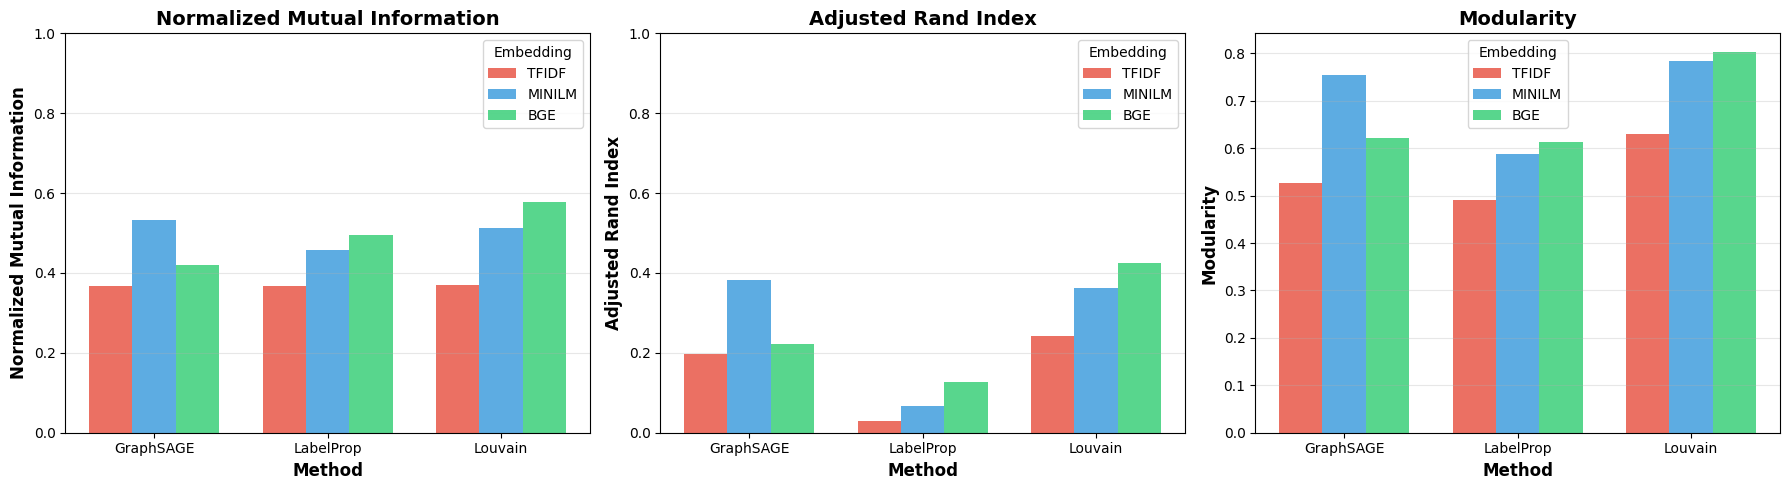


BEST PERFORMING COMBINATIONS:
   NMI: Louvain + BGE = 0.5788
   ARI: Louvain + BGE = 0.4243
   MODULARITY: Louvain + BGE = 0.8022


In [ ]:
# Display full results table
print("\n" + "="*80)
print("COMPLETE RESULTS TABLE")
print("="*80)
print(all_results_df[['method', 'graph', 'nmi', 'ari', 'modularity']].to_string(index=False))

# Create comprehensive visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['nmi', 'ari', 'modularity']
titles = ['Normalized Mutual Information', 'Adjusted Rand Index', 'Modularity']
colors = {'tfidf': '#e74c3c', 'minilm': '#3498db', 'bge': '#2ecc71'}

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx]

    # Prepare data
    pivot_data = all_results_df.pivot(index='method', columns='graph', values=metric)

    # Create grouped bar plot
    x = np.arange(len(pivot_data.index))
    width = 0.25

    for i, graph_name in enumerate(['tfidf', 'minilm', 'bge']):
        if graph_name in pivot_data.columns:
            ax.bar(x + i*width, pivot_data[graph_name], width,
                   label=graph_name.upper(), color=colors[graph_name], alpha=0.8)

    ax.set_xlabel('Method', fontsize=12, fontweight='bold')
    ax.set_ylabel(title, fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xticks(x + width)
    ax.set_xticklabels(pivot_data.index, rotation=0)
    ax.legend(title='Embedding')
    ax.grid(axis='y', alpha=0.3)

    # Set appropriate y-limits
    if metric != 'modularity':
        ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'final_comprehensive_comparison.png'),
            dpi=300, bbox_inches='tight')
plt.show()

print("\nBEST PERFORMING COMBINATIONS:")
for metric in ['nmi', 'ari', 'modularity']:
    best_idx = all_results_df[metric].idxmax()
    best = all_results_df.loc[best_idx]
    print(f"   {metric.upper()}: {best['method']} + {best['graph'].upper()} = {best[metric]:.4f}")


Looking at the results, we can draw some definitive conclusions. By all metrics louvain community detection on the bge embedding graph performed the best, closely followed by GraphSAGE on the minilm embedding graph except in modularity. In all cases minilm and bge embedding graphs show significant improvement over the TF-IDF embedding graphs by all metrics. This indicates definitively that modern embedding generating methods are indeed an improvement over traditional encoding methods. Interestingly, while both label propogation and louvain community detection methods show a clear heirarchy of TF-IDF, minilm, and bge embeddings with the later performing the best, GraphSAGE sees minilm perform much better. Given the trend present in the simpler community detection methods and the bge embeddings performed the best overall, this may indicate that the base embeddings produced by bge are high enough quality that manipulation through modeling actually diminishes their quality. This has interesting implications, suggesting that if the underlying data is of high enough quality simpler graph-based community detection methods are preferable.